Notebook purpose

- Use various ml models to understand determinants of saving

In [13]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.aggregators as ag
import entropy.data.cleaners as cl
import entropy.data.make_data as md
import entropy.data.selectors as sl
import entropy.data.validators as vl
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh

sns.set_style()

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%load_ext autoreload
%autoreload 2


fs = s3fs.S3FileSystem(profile="3di")

month = pd.Grouper(key="date", freq="m")
idx_cols = ["user_id", month]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [2]:
df = hd.read_txn_data("X77")
dfa = hd.read_analysis_data("X77")
dfs = hd.read_txn_data("777")

Time for read_txn_data                 : 29.10 seconds
Time for read_analysis_data            : 0.77 seconds
Time for read_txn_data                 : 2.31 seconds


In [3]:
# tmp fixes
dfa = dfa.rename(columns={"id": "has_od_fees"})

Defind index of user-months for series subsetting

In [4]:
dfa_user_months = dfa.set_index(["user_id", "date"]).index

Add counts

In [5]:
def counts(df, cat):
    """User-month txn counts by spend catetory."""
    group_cols = idx_cols + [cat]
    return (
        df.loc[df.tag_group.eq("spend") & df.debit]
        .groupby(group_cols, observed=True)
        .size()
        .unstack()
        .fillna(0)
        .rename(columns=lambda x: "count_" + x)
    )


s = counts(df, "tag").reset_index()
dfa = dfa.merge(s, how="left", validate="1:1")

Case study generator

In [6]:
def random_user_data(df, cols="count"):
    """Return counts for random user.

    Args:
    df: Analysis df with spend tag category counts.
    cols: Group of columns from {count, spend}.
    """
    user = np.random.choice(df.user_id.unique())
    return df[df.user_id.eq(user)].filter(regex=f"^{cols}")


random_user_data(dfa).head(10)

,count_communication,count_services,count_household,count_finance,count_other_spend,count_retail,count_motor,count_travel,count_hobbies
7244,2.0,3.0,5.0,1.0,2.0,0.0,0.0,20.0,1.0
7245,2.0,3.0,4.0,1.0,0.0,0.0,0.0,19.0,1.0
7246,2.0,3.0,3.0,1.0,0.0,0.0,0.0,19.0,1.0
7247,2.0,2.0,3.0,1.0,1.0,0.0,0.0,22.0,1.0
7248,2.0,3.0,4.0,1.0,0.0,0.0,0.0,11.0,1.0
7249,3.0,5.0,5.0,1.0,0.0,0.0,0.0,21.0,1.0
7250,2.0,2.0,7.0,1.0,0.0,0.0,0.0,21.0,1.0
7251,2.0,2.0,6.0,1.0,0.0,0.0,0.0,20.0,1.0
7252,2.0,2.0,5.0,2.0,1.0,0.0,0.0,8.0,1.0
7253,2.0,3.0,4.0,1.0,1.0,0.0,0.0,21.0,1.0


In [7]:
random_user_data(dfa, cols="spend").head(10)

,spend_communication,spend_services,spend_household,spend_finance,spend_other_spend,spend_retail,spend_motor,spend_travel,spend_hobbies
1594,0.00000,0.03489,0.03224,0.00330,0.45594,0.02949,0.05301,0.01135,0.00999
1595,0.05794,0.15572,0.02512,0.00930,0.13583,0.09386,0.11257,0.00000,0.00999
1596,0.05025,0.15974,0.03180,0.00330,0.10000,0.09858,0.04005,0.00000,0.00999
1597,0.06796,0.17124,0.01700,0.01530,0.08000,0.07857,0.05704,0.00800,0.00999
1598,0.03398,0.21214,0.06078,0.00330,0.14917,0.05557,0.06049,0.08610,0.00999
1599,0.03568,0.15075,0.04485,0.00330,0.08116,0.08817,0.09529,0.00000,0.00999
1600,0.03728,0.17886,0.14077,0.00330,0.19267,0.10303,0.09967,0.08285,0.00999
1601,0.03558,0.09926,0.01437,0.18678,0.13000,0.02992,0.02501,0.13268,0.00999
1602,0.00000,0.05135,0.07155,0.09620,0.16955,0.08358,0.04112,0.35452,0.00999
1603,0.06936,0.51929,0.06577,0.10183,0.28126,0.23596,0.06300,0.01275,0.00999


In [8]:
counts = dfa.filter(regex="^count")
spends = dfa.filter(regex="^spend")

## Counts

Can counts profile explain saving?

Preprocess data

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler())
counts_prep = pipe.fit_transform(counts)

Reduce dimensionality

In [10]:
from sklearn.decomposition import PCA

counts_pc = PCA().fit_transform(counts_prep)

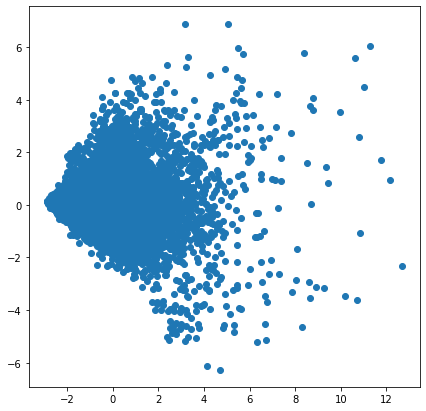

In [14]:
def pc_scatter(data, ndims=2, **kwargs):
    args = [data[:, dim] for dim in range(ndims)]
    proj = "3d" if ndims == 3 else None

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(projection=proj))
    ax.scatter(*args, **kwargs)


pc_scatter(counts_pc, ndims=2)

K-means clustering

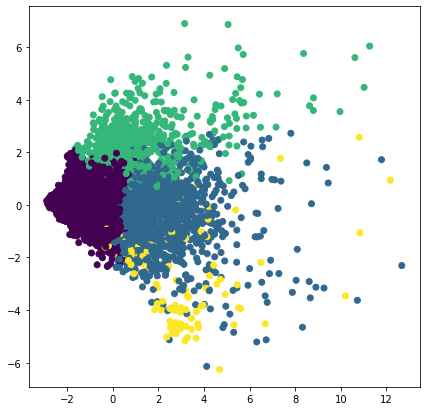

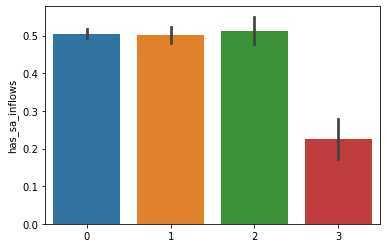

In [56]:
from sklearn.cluster import KMeans

n_clusters = 4

km = KMeans(n_clusters=n_clusters, random_state=2312).fit(counts_prep)
label = km.labels_

pc_scatter(counts_pc, ndims=2, c=label)

fig, ax = plt.subplots()
sns.barplot(x=label, y=dfa.has_sa_inflows);

How do PCs correlate with entropy measures?

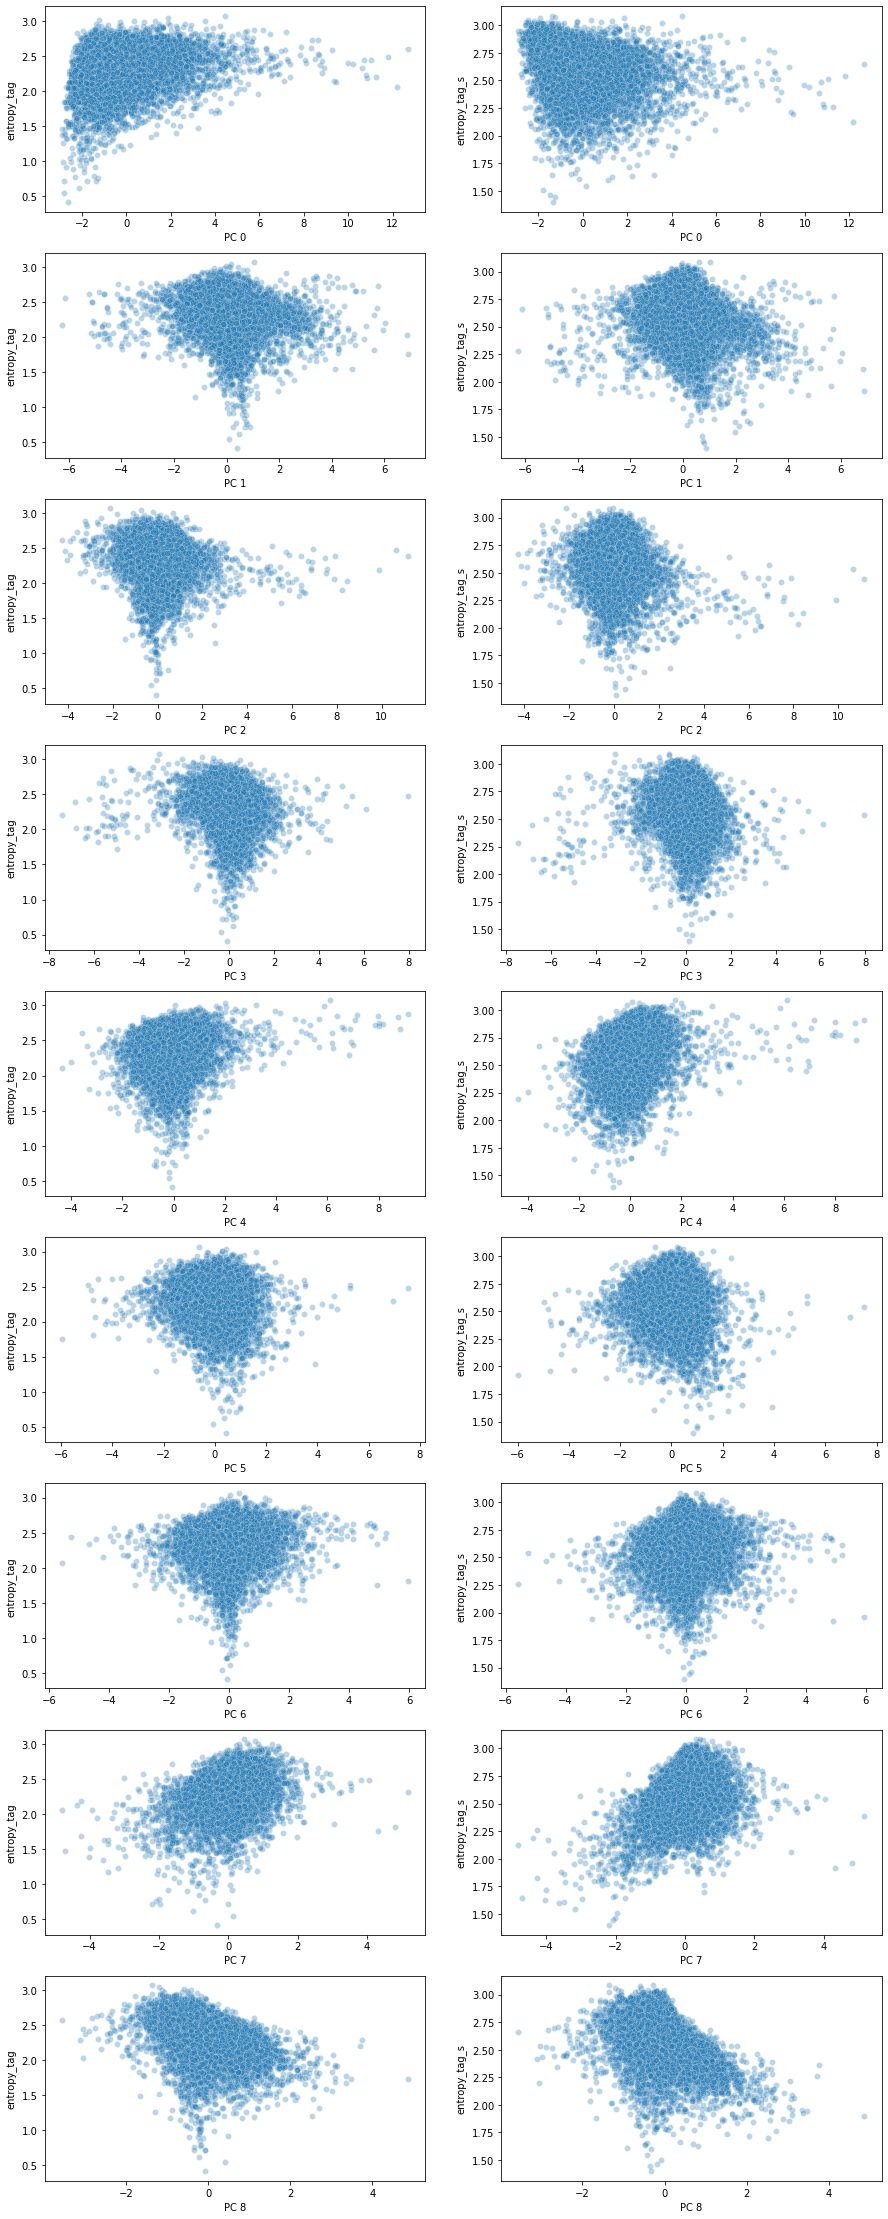

In [17]:
fig, ax = plt.subplots(9, 2, figsize=(15, 40))
row, col = 0, 0
for i in range(9):

    sns.scatterplot(
        y=dfa.entropy_tag,
        x=new[:, i],
        alpha=0.3,
        ax=ax[i, 0],
    )
    sns.scatterplot(
        y=dfa.entropy_tag_s,
        x=new[:, i],
        alpha=0.3,
        ax=ax[i, 1],
    )
    ax[i, 0].set_xlabel(f"PC {i}")
    ax[i, 1].set_xlabel(f"PC {i}")

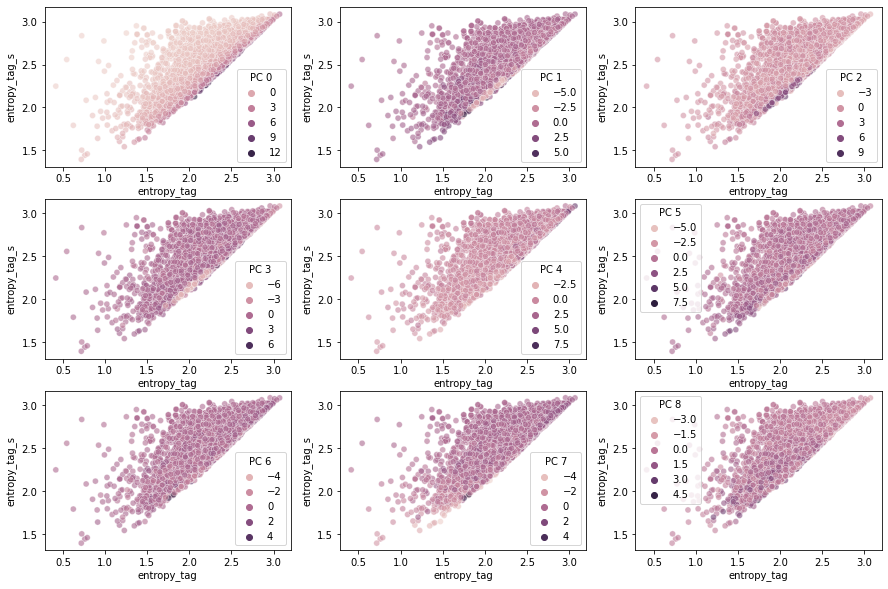

In [19]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
for i in range(9):
    row, col = i // 3, i % 3
    sns.scatterplot(
        x=dfa.entropy_tag,
        y=dfa.entropy_tag_s,
        hue=new[:, i],
        alpha=0.6,
        ax=ax[row, col],
    )
    ax[row, col].legend(title=f"PC {i}")

How do PCs correlate with unique transactions?

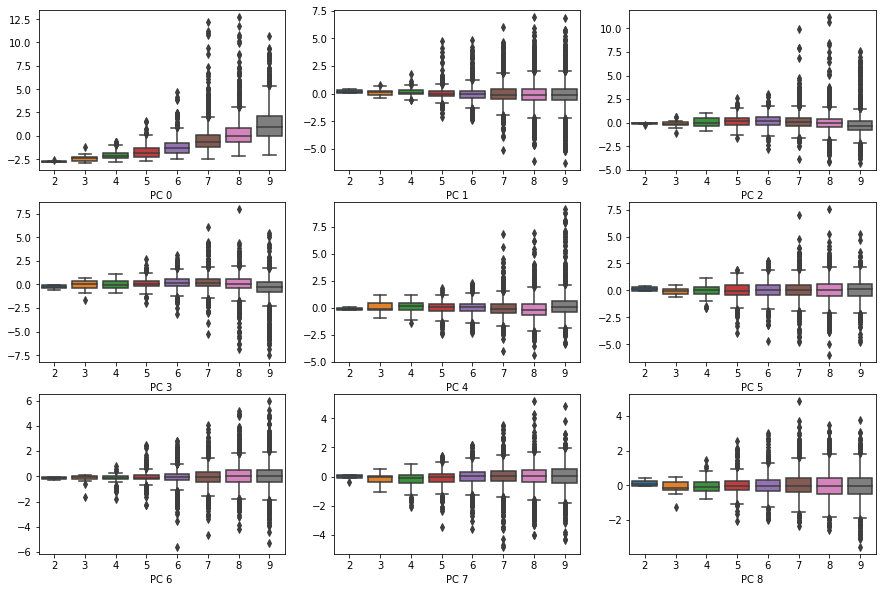

In [20]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
for i in range(9):
    row, col = i // 3, i % 3
    sns.boxplot(
        x=dfa.nunique_tag,
        y=new[:, i],
        ax=ax[row, col],
    )
    ax[row, col].set_xlabel(f"PC {i}")